# Importing Necessary Libraries and Data

In [106]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")



### Reading the input files

In [107]:
pd.options.display.max_columns=100 # to see columns 
df_store = pd.read_csv('../input/walmart-sales-forecast/stores.csv') #store data
df_train = pd.read_csv('../input/walmart-sales-forecast/train.csv') # train set
df_features = pd.read_csv('../input/walmart-sales-forecast/features.csv') #external information

# Observing and Merging The Three Dataframes

In [108]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [109]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [110]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [111]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [112]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column
df.head() # last ready data set

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [113]:
df.shape

(421570, 16)

# Store & Department Numbers

In [114]:
df['Store'].nunique() # number of different values

45

In [115]:
df['Dept'].nunique() # number of different values

81

We will observe average weekly sales for each store and each department to see if there is any weird values.

In [116]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

Store numbers begin from 1 to 45, department numbers are from 1 to 99, but some numbers are missing such as there is no 88 or 89 etc. Total number of departments is 81. 

From the pivot table, it is obviously seen that there are some wrong values such as there are 0 and minus values for weekly sales. But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week. So, we will change this values.

In [117]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


1358 rows in 421570 rows means 0.3%, so we can delete and ignore these rows which contains wrong sales values.

In [118]:
df = df.loc[df['Weekly_Sales'] > 0]

In [119]:
df.shape # new data shape

(420212, 16)

# Date

In [120]:
df['Date'].head(5).append(df['Date'].tail(5)) # to see first and last 5 rows.

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

Our data is from 5th of February 2010 to 26th of October 2012.  

# IsHoliday column

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

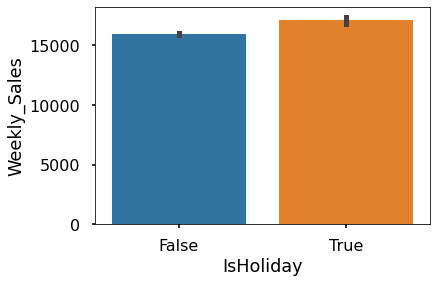

In [121]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [122]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [123]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

To see differences between holiday types we created new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False. 

In [124]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [125]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [126]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [127]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

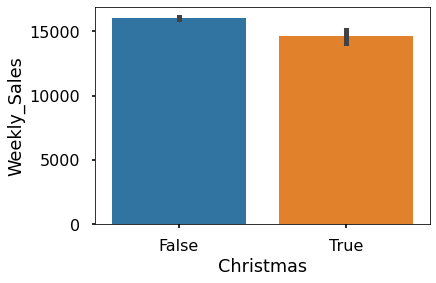

In [128]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

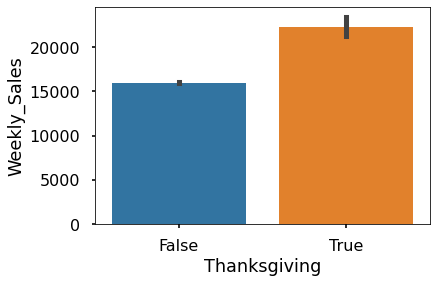

In [129]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<AxesSubplot:xlabel='Super_Bowl', ylabel='Weekly_Sales'>

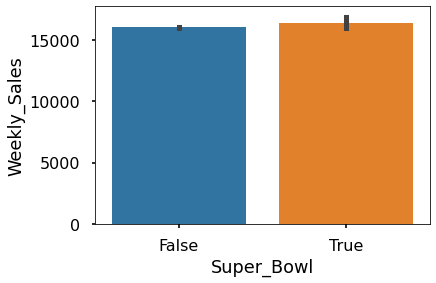

In [130]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<AxesSubplot:xlabel='Labor_Day', ylabel='Weekly_Sales'>

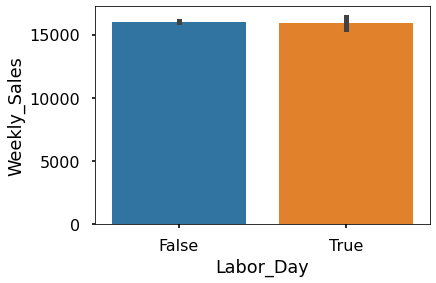

In [131]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

# Type Effect on Holidays

There are three different store types in the data as A, B and C.

In [132]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas 

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [133]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [134]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [135]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

I want to see percentages of store types.

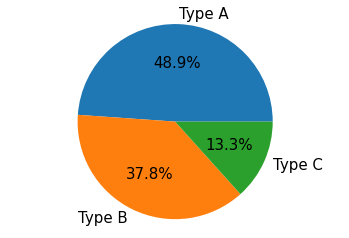

In [136]:
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [137]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

Nearly, half of the stores are belongs to Type A.

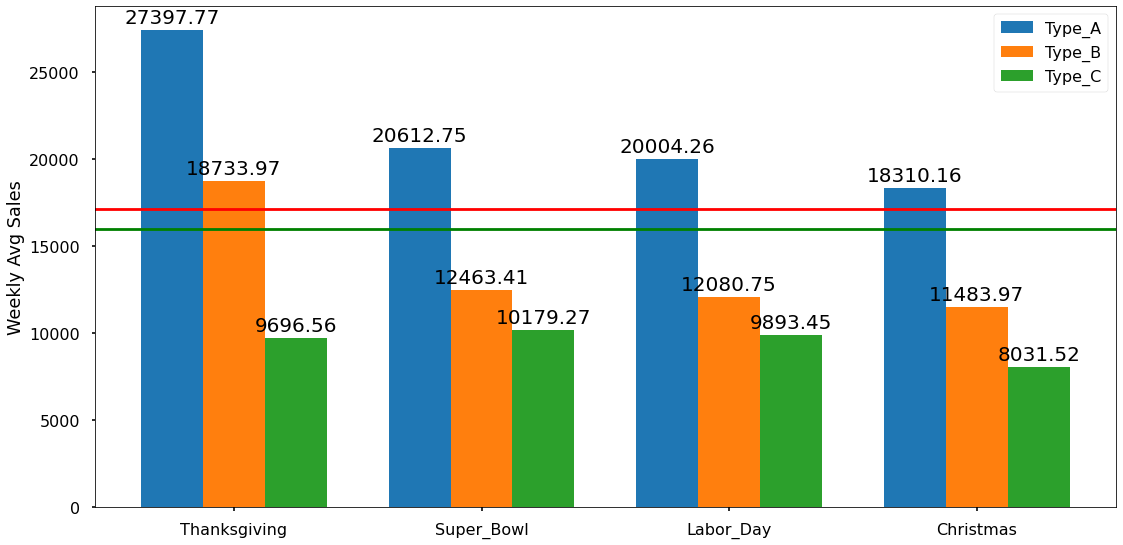

In [138]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

In [139]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


Also, it is not surprise that top 5 highest weekly sales are belongs to Thanksgiving weeks.

# To See the Size - Type Relation

In [140]:
df_store.groupby('Type').describe()['Size'].round(2) # See the Size-Type relation

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


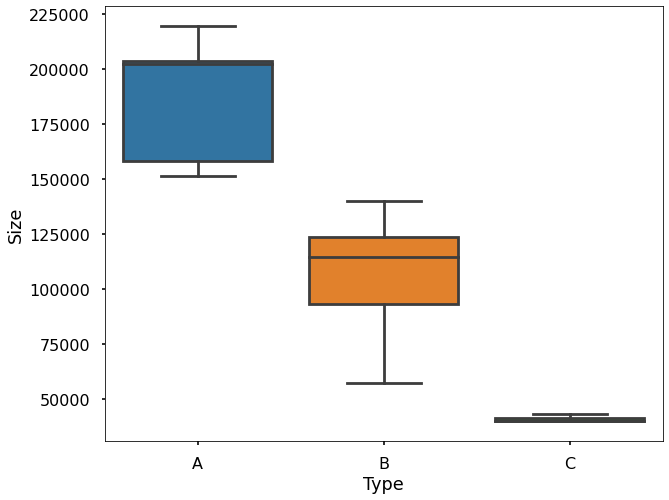

In [141]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales. And, Walmart classify stores according to their sizes according to graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

# Markdown Columns

Walmart gave markdown columns to see the effect if markdowns on sales. When we check columns, there are many NaN values for markdowns. We decided to change them with 0, because if there is markdown in the row, it is shown with numbres. So, if we can write 0, it shows there is no markdown at that date.

In [142]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [143]:
df = df.fillna(0) # filling null's with 0

In [144]:
df.isna().sum() # last null check

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [145]:
df.describe() # to see weird statistical things

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


Minimum value for weekly sales is 0.01. Most probably, this value is not true but it is preferable not to change them now. Because, there are many departments and many stores. It takes too much time to check each department for each store (45 store for 81 departments). So, we take averages for EDA. 

# Deeper Look in Sales

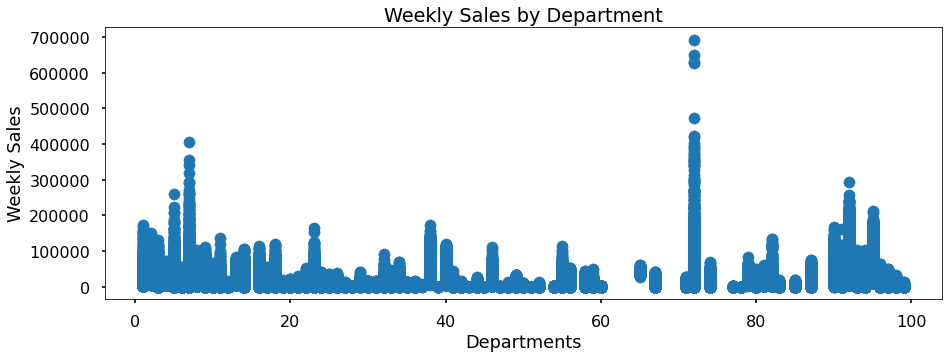

In [146]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

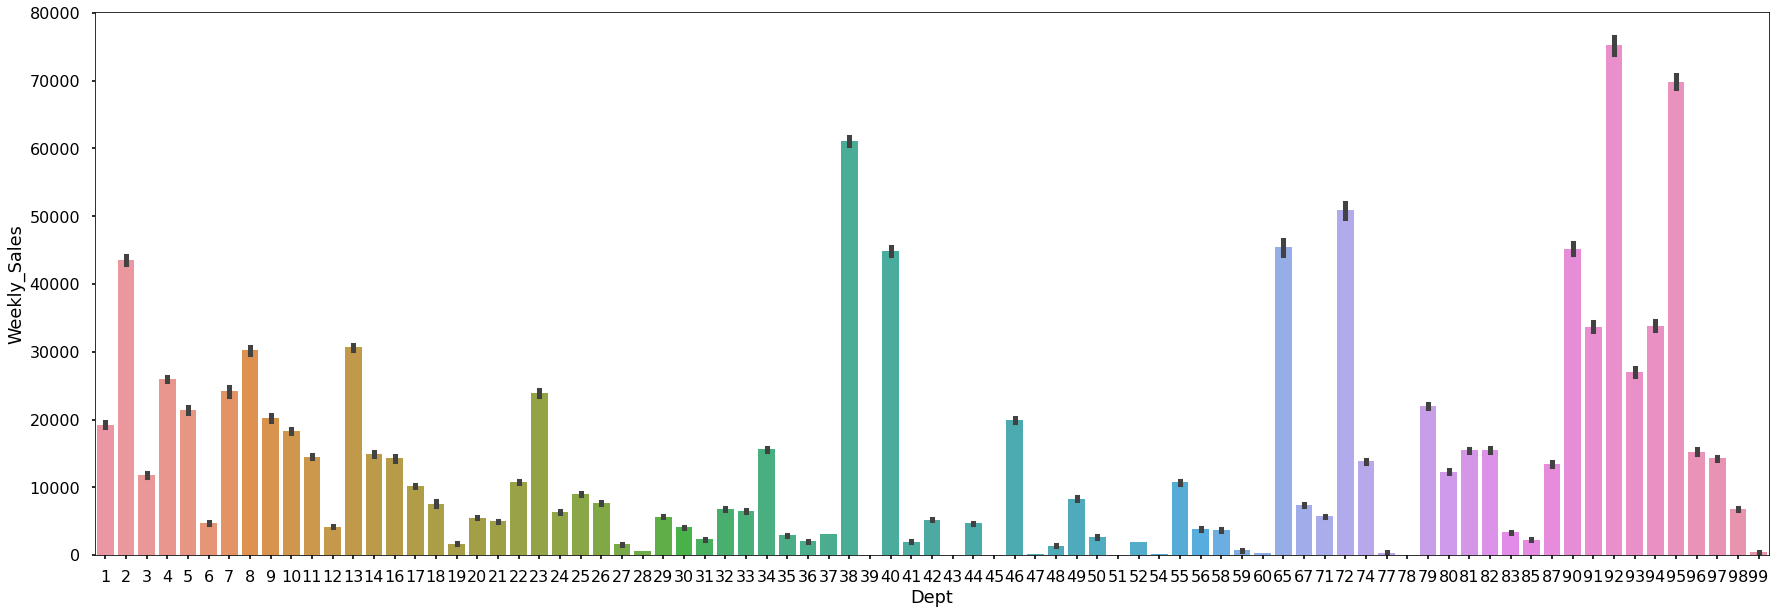

In [147]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

From the first graph, it is seen that one department between 60-80(I assume it is 72), has higher sales values. But, when we take the averages, it is seen that department 92 has higher mean sales. Department 72 is seasonal department. It has higher values is some seasons but on average 92 is higher.

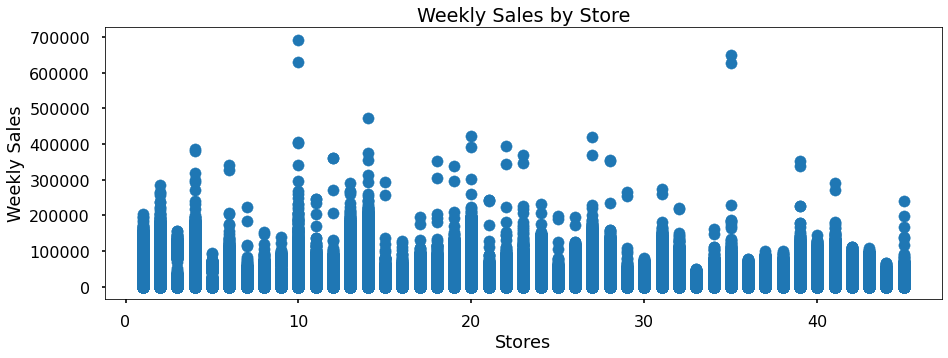

In [148]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

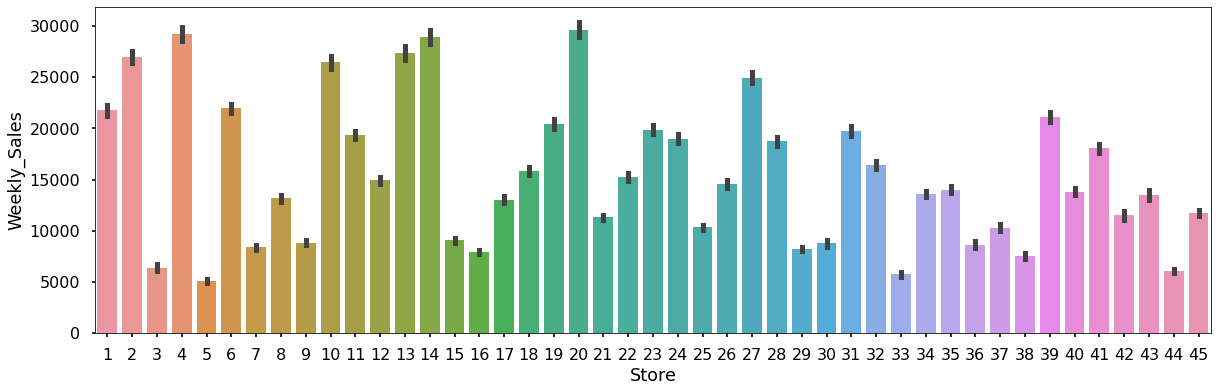

In [149]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

Same thing happens in stores. From the first graph, some stores has higher sales but on average store 20 is the best and 4 and 14 following it.

# Changing Date to Datetime and Creating New Columns

In [150]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

In [151]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [152]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='month'>

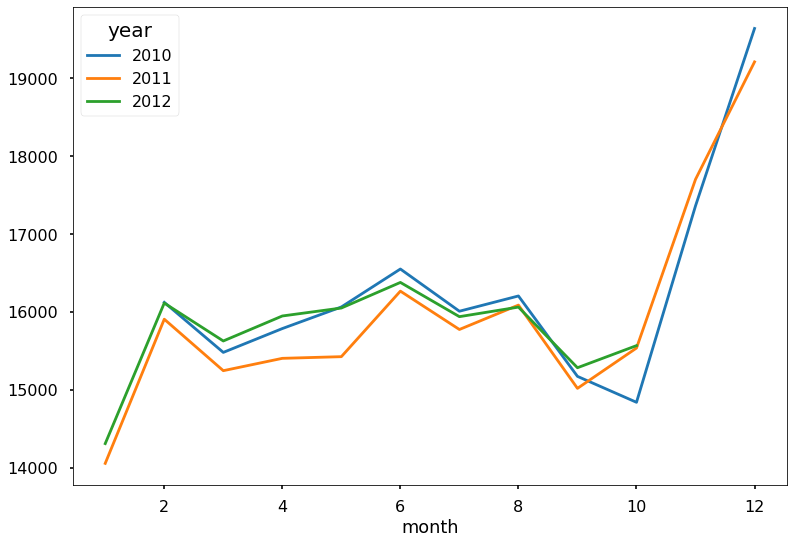

In [153]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

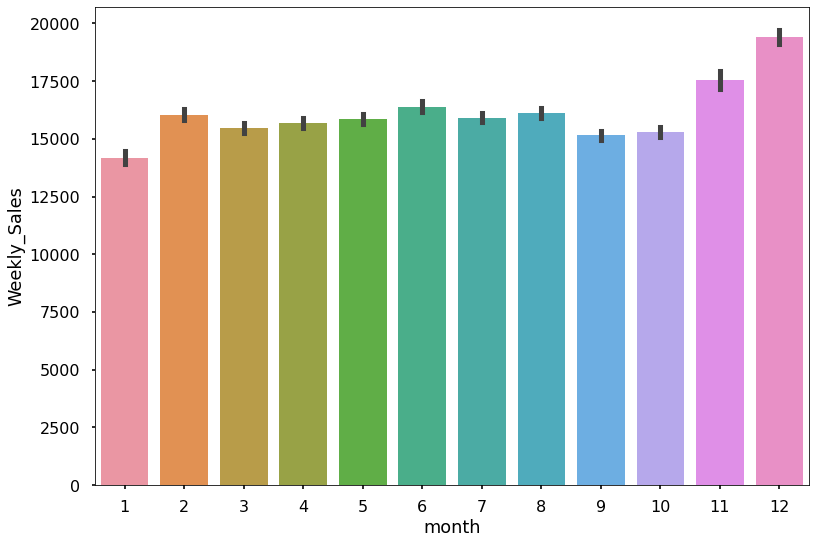

In [154]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

In [155]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed. 

<AxesSubplot:xlabel='week'>

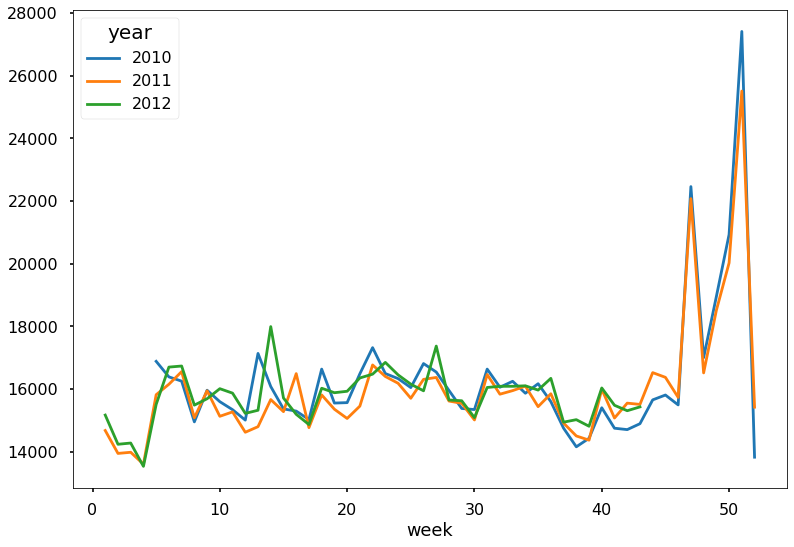

In [156]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

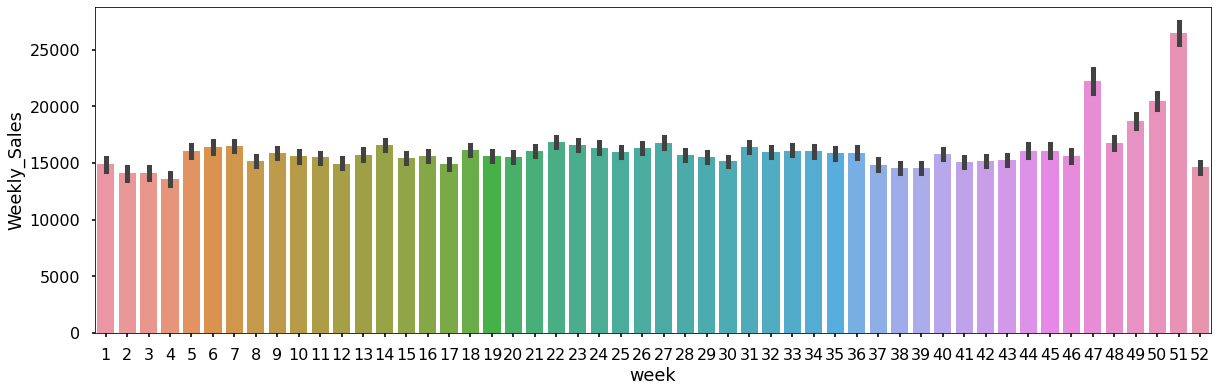

In [157]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

# Analyzing effects of Fuel Price, CPI , Unemployment and Temperature.

<AxesSubplot:xlabel='Fuel_Price'>

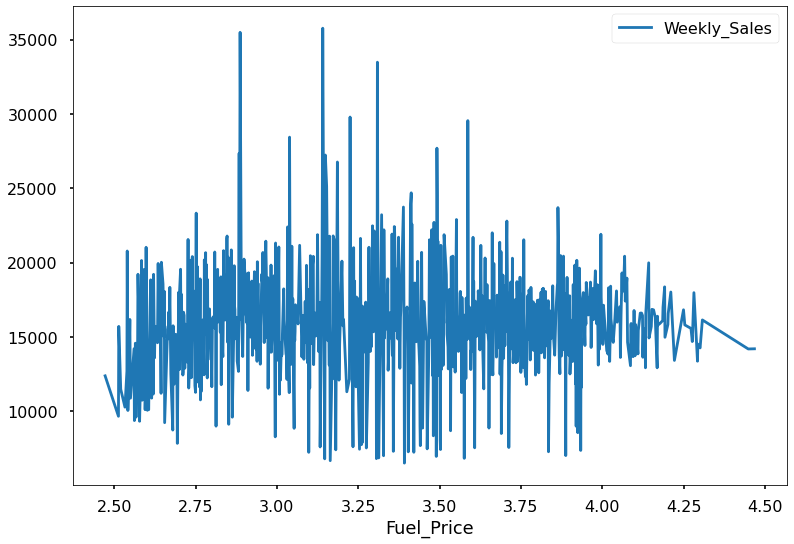

In [158]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<AxesSubplot:xlabel='Temperature'>

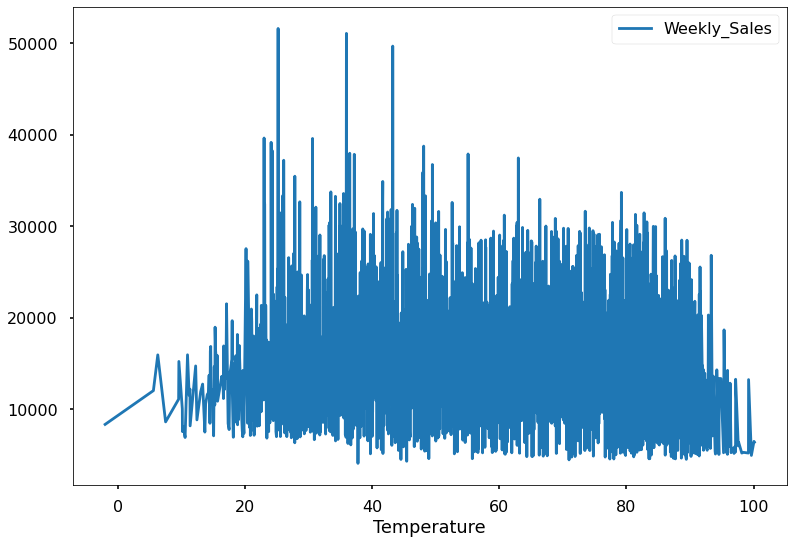

In [159]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<AxesSubplot:xlabel='CPI'>

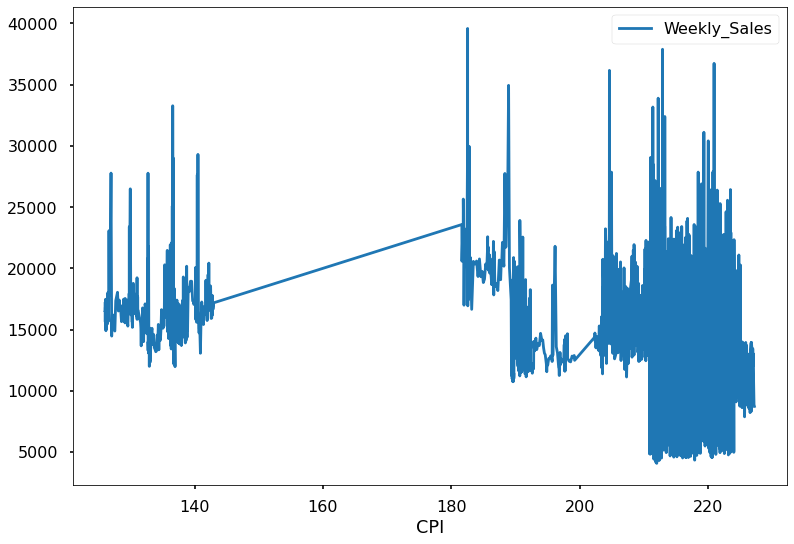

In [160]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<AxesSubplot:xlabel='Unemployment'>

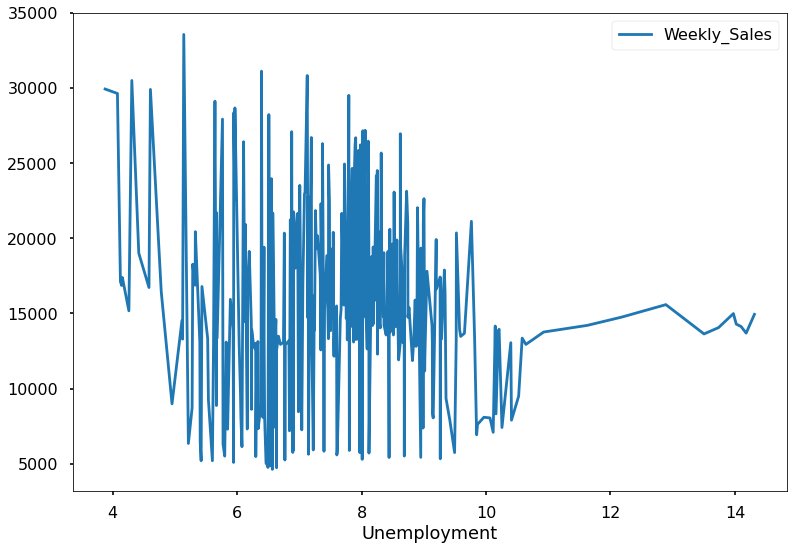

In [161]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 also.

In [162]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

# Findings and Explorations

# Cleaning Process

- The data has no too much missing values. All columns was checked. 
- We choose rows which has higher than 0 weekly sales. Minus values are 0.3% of data. So, we dropped them.
- Null values in markdowns changed to zero. Because, they were written as null if there were no markdown on this department. 

# Explorations & Findings

- There are 45 stores and 81 department in data. Departments are not same in all stores. 
- Although department 72 has higher weekly sales values, on average department 92 is the best. It shows us, some departments has higher values as seasonal like Thanksgiving. It is consistant when we look at the top 5 sales in data, all of them belongs to 72th department at Thanksgiving holiday time. 
- Although stores 10 and 35 have higher weekly sales values sometimes, in general average store 20 and store 4 are on the first and second rank. It means that some areas has higher seasonal sales. 
- Stores has 3 types as A, B and C according to their sizes. Almost half of the stores are bigger than 150000 and categorized as A. According to type, sales of the stores are changing.
- As expected, holiday average sales are higher than normal dates.
- Christmas holiday introduces as the last days of the year. But people generally shop at 51th week. So, when we look at the total sales of holidays, Thankgiving has higher sales between them which was assigned by Walmart.
- Year 2010 has higher sales than 2011 and 2012. But, November and December sales are not in the data for 2012. Even without highest sale months, 2012 is not significantly less than 2010, so after adding last two months, it can be first.
- It is obviously seen that week 51 and 47 have higher values and 50-48 weeks follow them. Interestingly, 5th top sales belongs to 22th week of the year. This results show that Christmas, Thankgiving and Black Friday are very important than other weeks for sales and 5th important time is 22th week of the year and it is end of the May, when schools are closed. Most probably, people are preparing for holiday at the end of the May. 
- January sales are significantly less than other months. This is the result of November and December high sales. After two high sales month, people prefer to pay less on January.
- CPI, temperature, unemployment rate and fuel price have no pattern on weekly sales. 


# Further cleaning and analysis

In [163]:
pd.options.display.max_columns=100 # to see columns 
df = pd.read_csv('./clean_data.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

# Encoding the Data 

For preprocessing our data, I will change holidays boolean values to 0-1 and replace type of the stores from A, B, C to 1, 2, 3. 

In [164]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [165]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [166]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

# Observation of Interactions between Features

Firstly, we will drop divided holiday columns from my data and try without them.

In [167]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

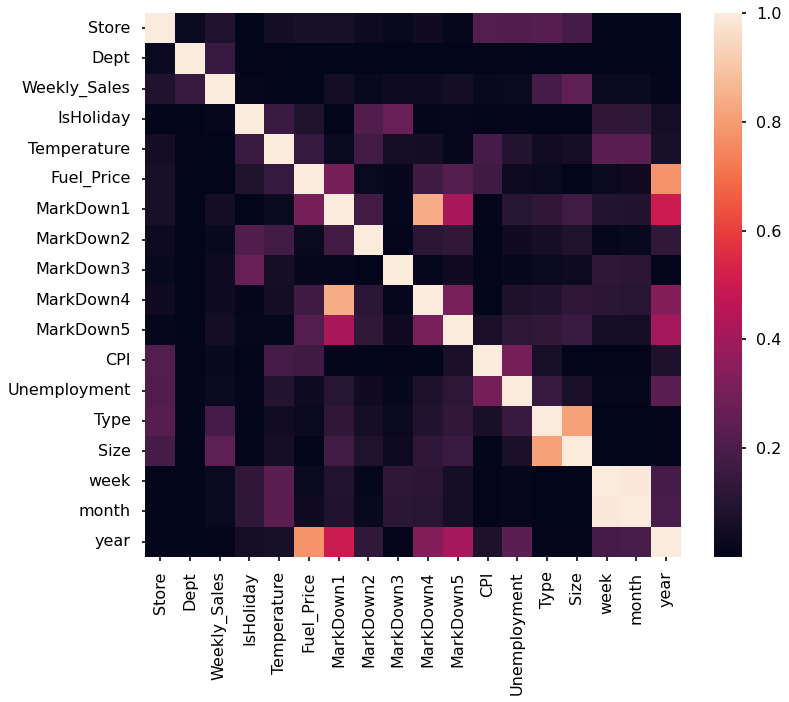

In [168]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales, so we will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, we will drop them also. It can create multicollinearity problem, maybe. So, first we will try without them.

In [169]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

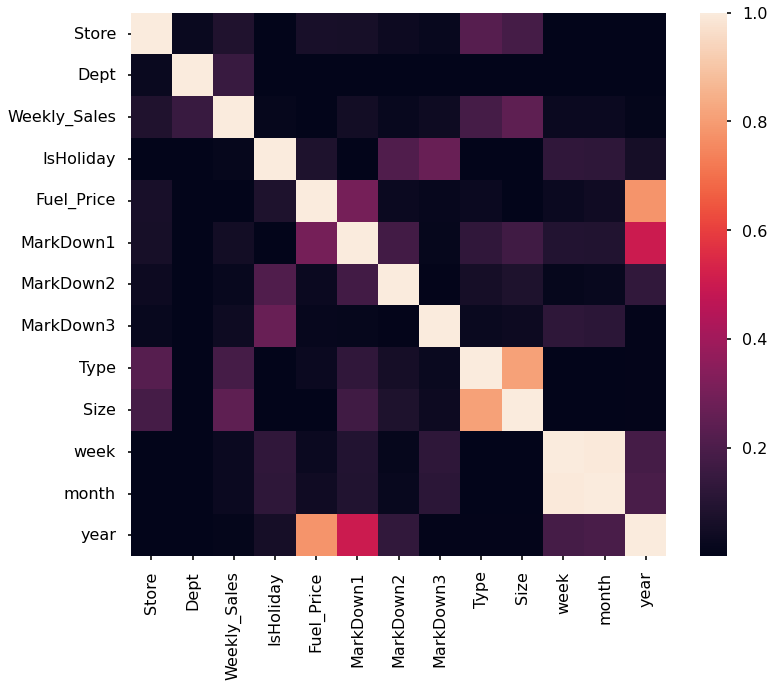

In [170]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations without dropping columns
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

# Time Series Models

In [178]:
df_w = df.copy()
df.head() # to see my data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


In [67]:
weekly_averages = df['Weekly_Sales'].mean()
weekly_averages

16033.114591373213

In [68]:
df["Date"] = pd.to_datetime(df["Date"]) #changing data to datetime for decomposing

In [69]:
df.set_index('Date', inplace=True) #seting date as index

# Plotting Sales

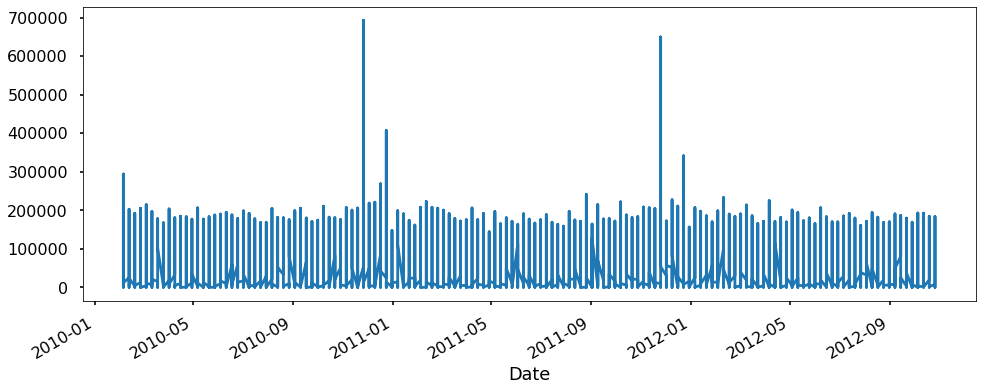

In [70]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In this data, there are lots of same data values. So, we will collect them together as weekly.

In [71]:
df_week = df.resample('W').mean() #resample data as weekly

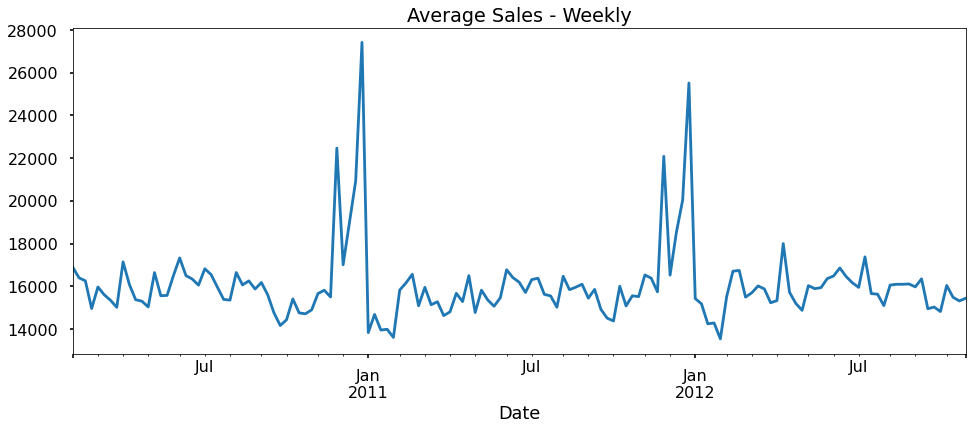

In [72]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

With the collecting data as weekly, we can see average sales clearly. To see monthly pattern , we resampled my data to monthly also.

In [73]:
df_month = df.resample('MS').mean() # resampling as monthly

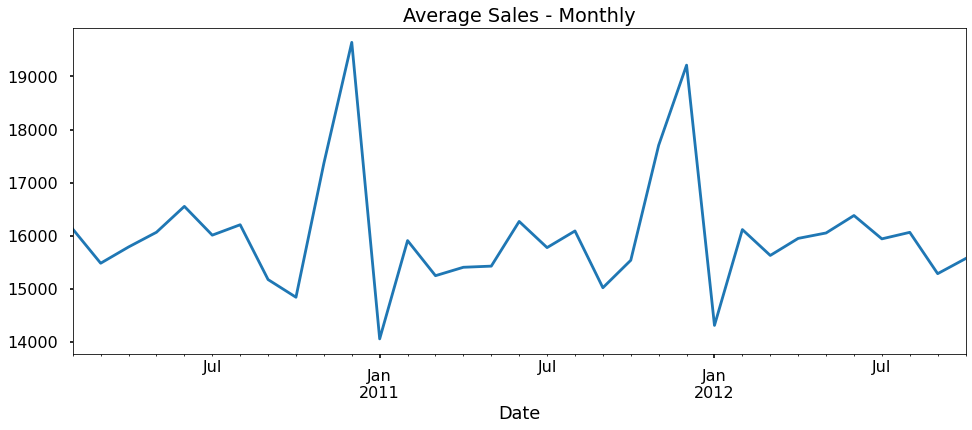

In [74]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

When we turned data to monthly, some patterns in weekly data were lost. So, we will continue with weekly resampled data.

# To Observe 2-weeks Rolling Mean and Std

My data is non-stationary. So, we will try to find more stationary version on it. 

In [75]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

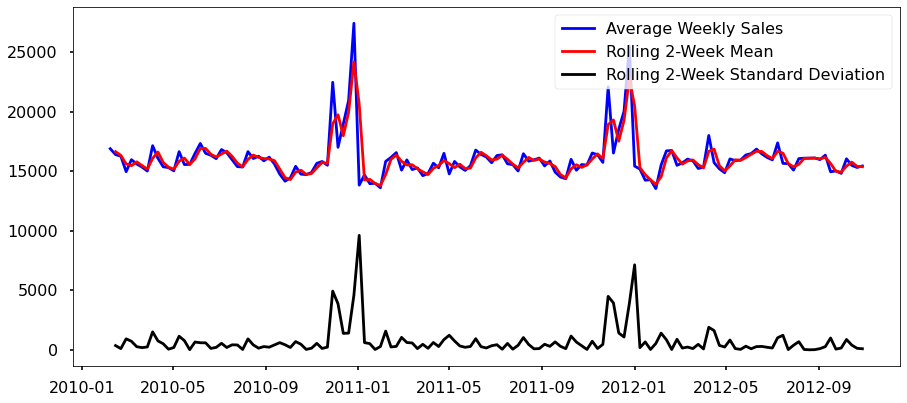

In [76]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

from above we can see where the seasonality is

# Adfuller Test to Make Sure

In [77]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737569,
 2.429049208204254e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

From test and my observations my data is not stationary. So, I will try to find more stationary version of it.

# Decomposing Weekly Data to Observe Seasonality

In [78]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data 

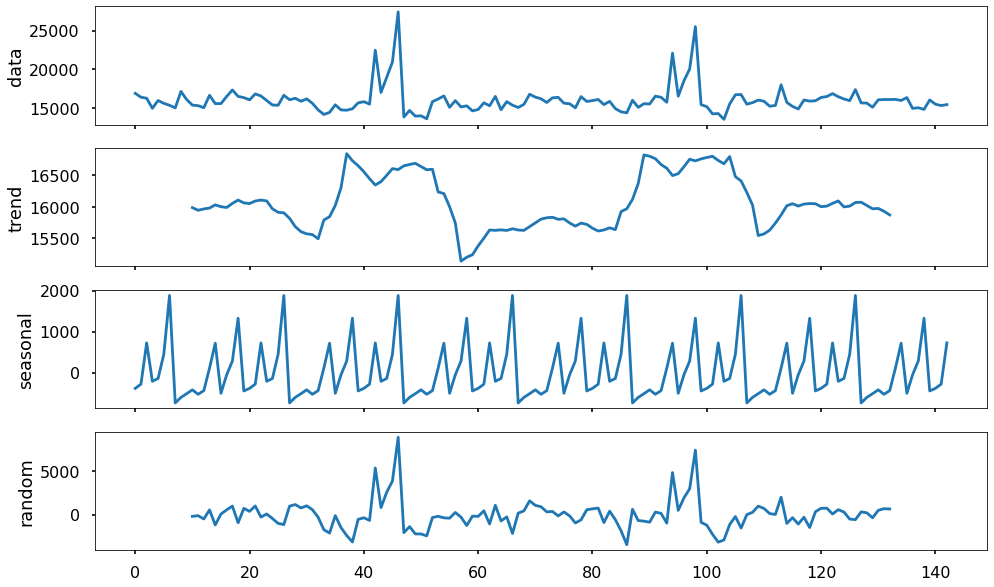

In [79]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps to tune my model.

 ## Running models on seasonal data

## Train-Test Split


We split them manually, not random to ensure continuity.

In [99]:
df_week_n = df_week.copy()
df_week_n = df_week_n['Weekly_Sales'].dropna() 
train_data_n = df_week_n [:int(0.7*(len(df_week_n )))]
test_data_n = df_week_n [int(0.7*(len(df_week_n ))):]

print('Train:', train_data_n.shape)
print('Test:', test_data_n.shape)

Train: (100,)
Test: (43,)


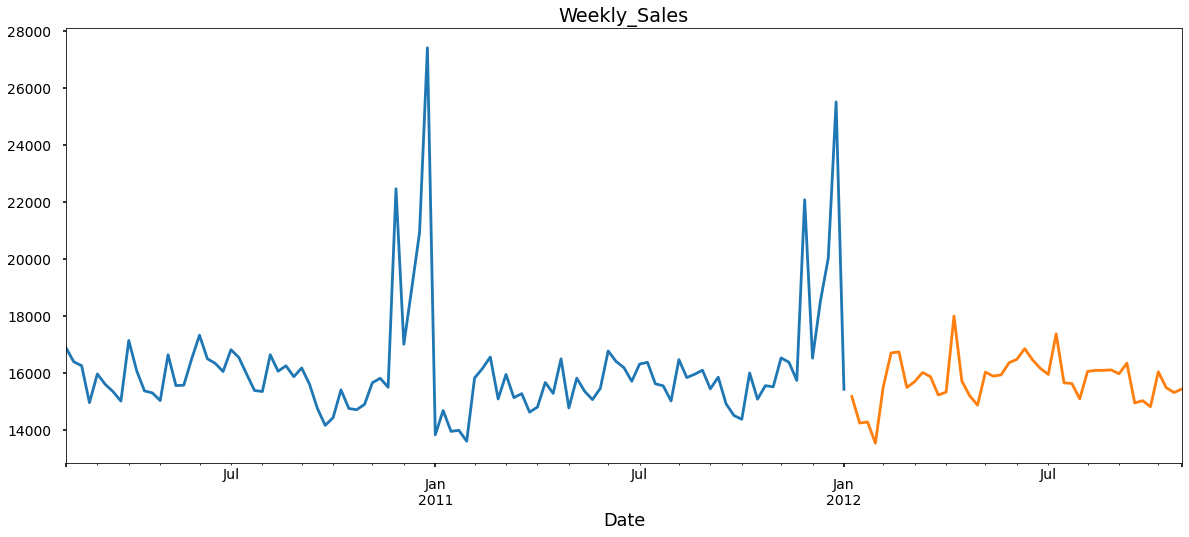

In [100]:
train_data_n.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data_n.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents train data, yellow is test data.

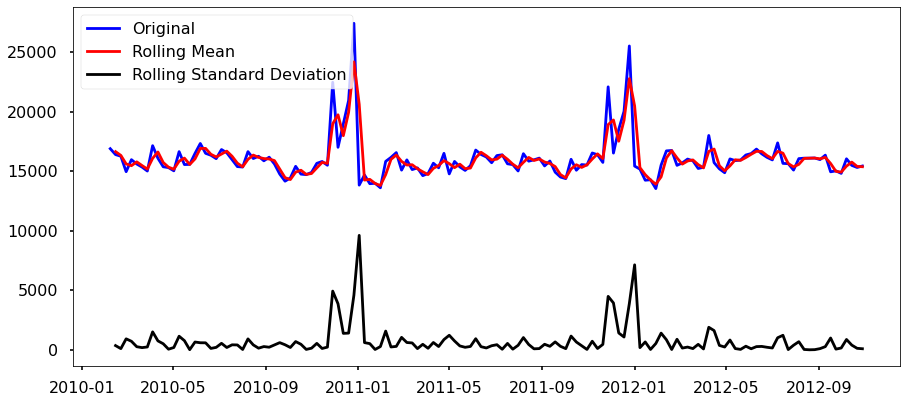

In [82]:
# taking mean and std of original data and plotting it
n_roll_mean = df_week_n.rolling(window=2, center=False).mean()
n_roll_std = df_week_n.rolling(window=2, center=False).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_n, color='blue',label='Original')
ax.plot(n_roll_mean, color='red', label='Rolling Mean')
ax.plot(n_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

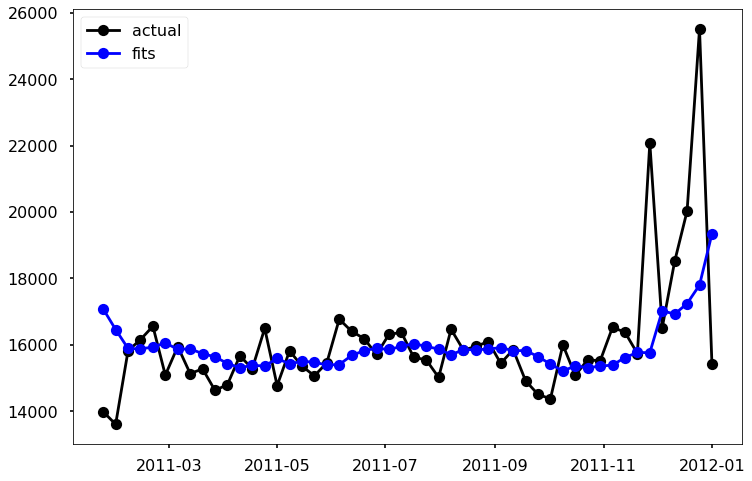

In [83]:
#SES
model_1 = sm.tsa.SimpleExpSmoothing(train_data_n, initialization_method="heuristic")
ses_model_1 = model_1.fit(smoothing_level=0.2, optimized=True)

##Forecasting with the trained SES
fcast1 = ses_model_1.forecast(3).rename(r"$\alpha=0.2$")
plt.figure(figsize=(12, 8)) 
plt.plot(train_data_n[50:], marker="o", color="black", label="actual") 
plt.plot(ses_model_1.fittedvalues[50:], marker="o", color="blue", label="fits") 
#(line1,) = plt.plot(fcast1, marker="o", color="red")
plt.legend(loc='upper left')
plt.show()

In [87]:
y_pred = ses_model_1.predict(start=1, end=len(test_data_n))
mae = mean_absolute_error(test_data_n, y_pred)
mse = mean_squared_error(test_data_n, y_pred)
mape = mean_absolute_percentage_error(test_data_n, y_pred)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f" MAE: {mae} or {(mae/weekly_averages):.3f}")
print(f" MSE: {mse}")
print(f" MAPE: {mape}")

 MAE: 595.8018384880152 or 0.037
 MSE: 745294.5647654549
 MAPE: 0.03848051952038025


## Removing outliers from the non-stationary data

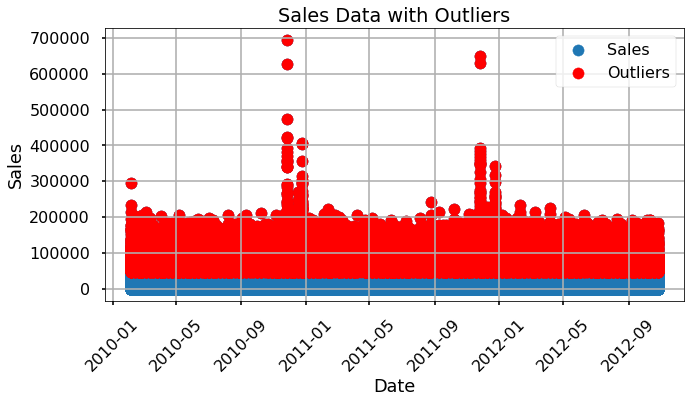

In [179]:

# Calculate IQR (Interquartile Range) for outlier detection
q1 = df_w['Weekly_Sales'].quantile(0.25)
q3 = df_w['Weekly_Sales'].quantile(0.75)
iqr = q3 - q1

# Identify potential outliers (values outside 1.5 IQR from quartiles)
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
outliers = df_w[(df_w['Weekly_Sales'] < lower_bound) | (df_w['Weekly_Sales'] > upper_bound)]

# Plot sales data with outliers highlighted
plt.figure(figsize=(10, 6))
plt.scatter(df_w['Date'], df_w['Weekly_Sales'], label='Sales')
plt.scatter(outliers['Date'], outliers['Weekly_Sales'], color='red', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data with Outliers')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [180]:
df_w.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


In [181]:
# Assuming you want to winsorize 5% on both tails
winsor_low = df_w['Weekly_Sales'].quantile(0.05)  # 5th percentile
winsor_high = df_w['Weekly_Sales'].quantile(0.95)  # 95th percentile

# Replace outliers with winsorized values
df_w['sales_winsorized'] = np.where(df_w['Weekly_Sales'] < winsor_low, winsor_low, df_w['Weekly_Sales'])
df_w['sales_winsorized'] = np.where(df_w['Weekly_Sales'] > winsor_high, winsor_high, df_w['sales_winsorized'])


In [182]:
df_w.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year,sales_winsorized
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010,24924.50
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010,50605.27
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010,13740.12
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010,39954.04
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010,32229.38


In [186]:
df_w["Date"] = pd.to_datetime(df_w["Date"]) #changing data to datetime for decomposin
df_w.set_index('Date', inplace=True) #seting date as index
df_w2 = df_w.resample('W').mean() #resample data as weekly

KeyError: 'Date'

In [192]:
df_week_n = df_w2['sales_winsorized'].dropna() 
train_data_n = df_week_n [:int(0.7*(len(df_week_n )))]
test_data_n = df_week_n [int(0.7*(len(df_week_n ))):]

print('Train:', train_data_n.shape)
print('Test:', test_data_n.shape)

Train: (100,)
Test: (43,)


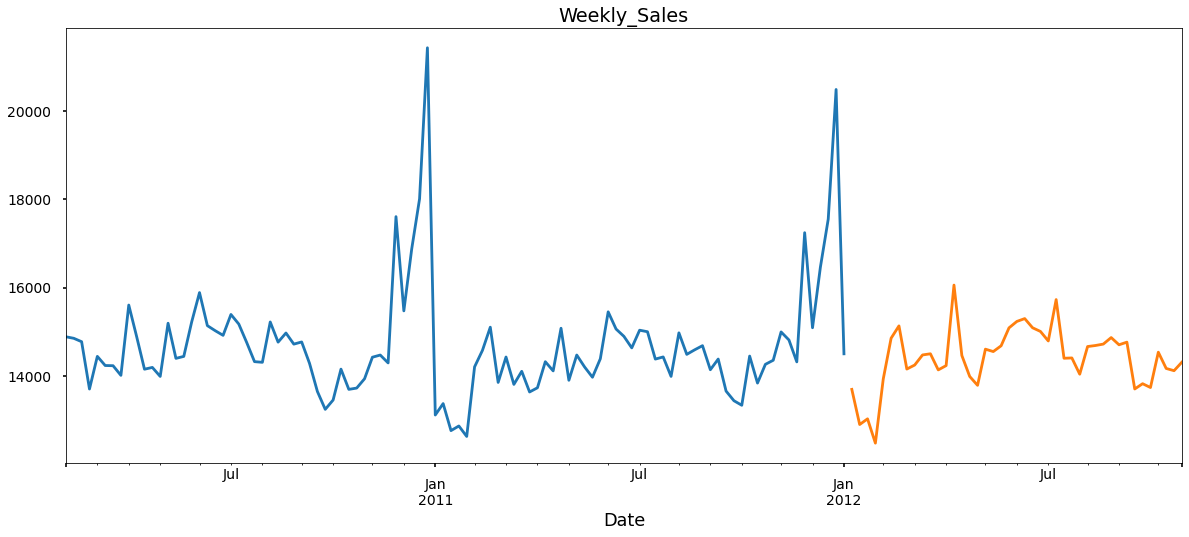

In [193]:
train_data_n.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data_n.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

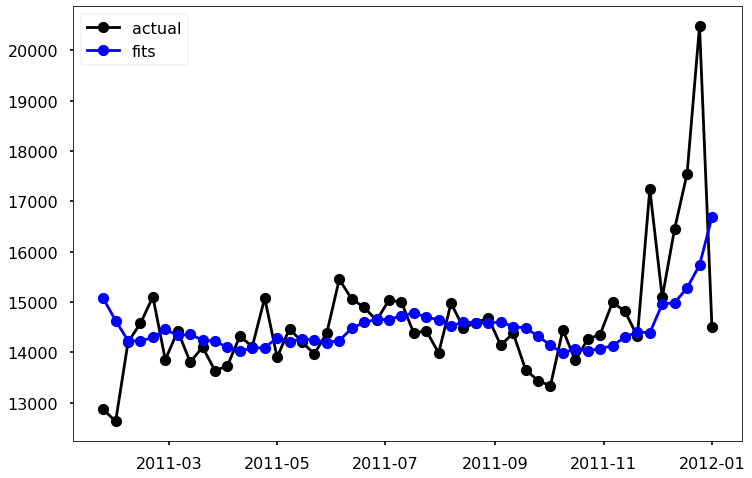

In [194]:
#SES
model_1 = sm.tsa.SimpleExpSmoothing(train_data_n, initialization_method="heuristic")
ses_model_1 = model_1.fit(smoothing_level=0.2, optimized=True)

##Forecasting with the trained SES
fcast1 = ses_model_1.forecast(3).rename(r"$\alpha=0.2$")
plt.figure(figsize=(12, 8)) 
plt.plot(train_data_n[50:], marker="o", color="black", label="actual") 
plt.plot(ses_model_1.fittedvalues[50:], marker="o", color="blue", label="fits") 
#(line1,) = plt.plot(fcast1, marker="o", color="red")
plt.legend(loc='upper left')
plt.show()

In [195]:
y_pred = ses_model_1.predict(start=1, end=len(test_data_n))
mae = mean_absolute_error(test_data_n, y_pred)
mse = mean_squared_error(test_data_n, y_pred)
mape = mean_absolute_percentage_error(test_data_n, y_pred)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f" MAE: {mae} or {(mae/weekly_averages):.3f}")
print(f" MSE: {mse}")
print(f" MAPE: {mape}")

 MAE: 480.7136199538815 or 0.030
 MSE: 461104.82871700963
 MAPE: 0.034175289402350935


 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1720.930, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1708.362, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1703.338, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1703.260, Time=0.13 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1689.721, Time=0.10 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1690.990, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1702.135, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1703.423, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1705.144, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1707.108, Time=0.33 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1691.319, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1702.346, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1703.636, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1703.716, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1700.301, Time=0.34 sec
 ARIMA(3,0

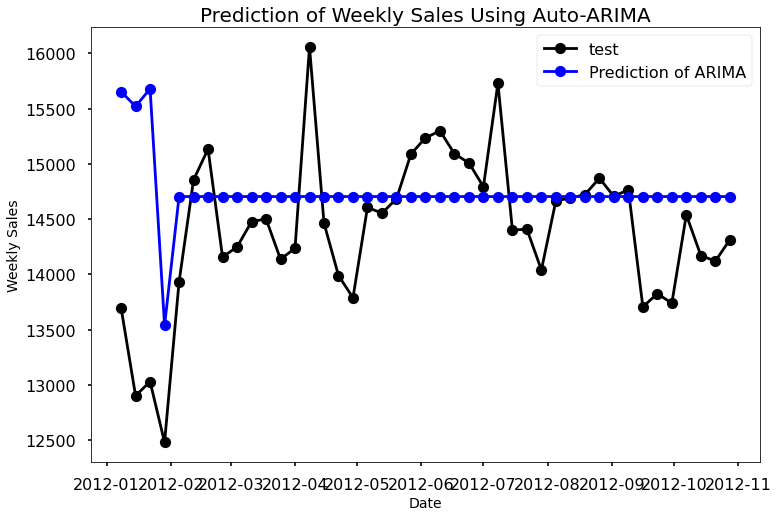

In [196]:
#Arima model

model_auto_arima = auto_arima(train_data_n, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_n)

y_pred_a = model_auto_arima.predict(n_periods=len(test_data_n))
#y_pred_a = pd.DataFrame(y_pred_a,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(12,8))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(test_data_n, marker="o", color="black", label='test') 
plt.plot(y_pred_a, marker="o", color="blue", label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [197]:
print(f" MAE: {mean_absolute_error(test_data_n, y_pred_a)}")
print(f" MSE: {mean_squared_error(test_data_n, y_pred_a)}")
print(f" MAPE: {mean_absolute_percentage_error(test_data_n, y_pred_a)}")


 MAE: 581.2649549171787
 MSE: 704475.5021137445
 MAPE: 0.041585272231166724


In [198]:
#SARIMA
sarima_model = sm.tsa.statespace.SARIMAX(train_data_n, order=(2,0,5), seasonal_order=(0,0,1,6), trend='c', enforce_invertibility=False)
sa_results = sarima_model.fit(disp=False)
print(sa_results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                    sales_winsorized   No. Observations:                  100
Model:             SARIMAX(2, 0, 5)x(0, 0, [1], 6)   Log Likelihood                -837.934
Date:                             Sat, 11 May 2024   AIC                           1695.868
Time:                                     12:47:14   BIC                           1721.919
Sample:                                 02-07-2010   HQIC                          1706.411
                                      - 01-01-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.582e+04   3.96e+04      0.400      0.689   -6.18e+04    9.34e+04
ar.L1         -0.0035      

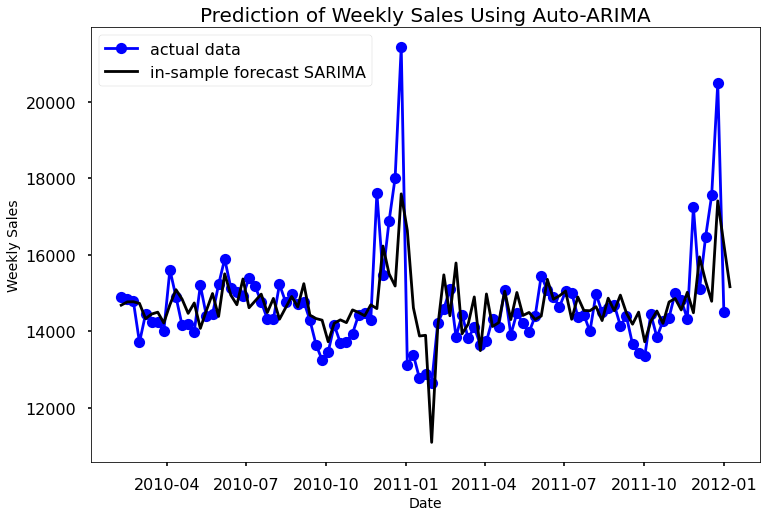

In [199]:
nforecast = len(test_data_n)
sa_predict = sa_results.get_prediction(end=sarima_model.nobs + nforecast)
#idx = np.arange(len(sa_predict.predicted_mean))
pred_ci = sa_predict.conf_int(alpha=0.5)

plt.figure(figsize=(12,8))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_n, marker="o", color="blue", label='actual data') 
#plt.plot(test_data_n, marker="o", color="yellow", label='Test') 
plt.plot(sa_predict.predicted_mean[:-nforecast], label='in-sample forecast SARIMA', color="black")
#plt.plot(sa_predict.predicted_mean[-nforecast:], 'k--', label='Out-of-sample Forecast', linestyle='--', linewidth=2, color="red")
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [200]:
y_pred_sa = sa_predict.predicted_mean[:-(nforecast + 1)]
print(f" MAE: {mean_absolute_error(train_data_n, y_pred_sa)}")
print(f" MSE: {mean_squared_error(train_data_n, y_pred_sa)}")
print(f" MAPE: {mean_absolute_percentage_error(train_data_n, y_pred_sa)}")


 MAE: 683.373457133074
 MSE: 1082817.0001130893
 MAPE: 0.044924631158823274


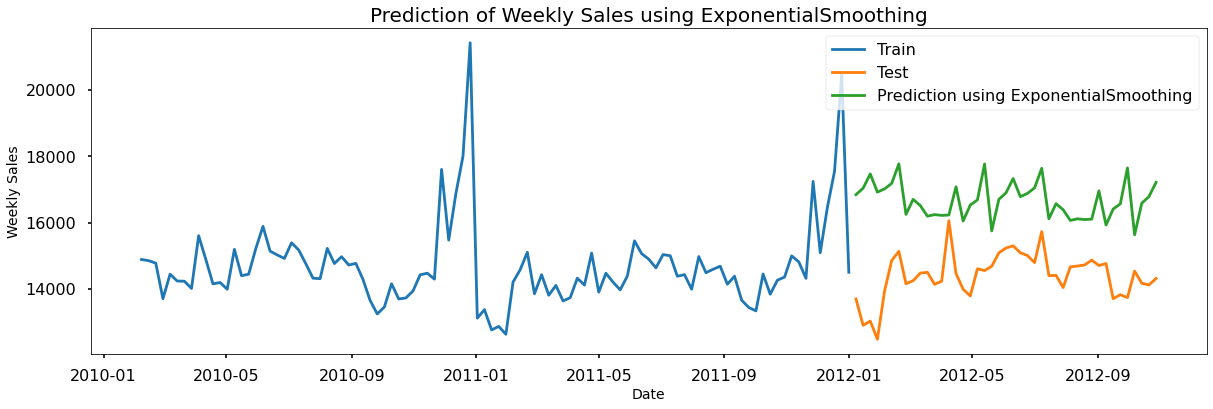

In [202]:
model_holt_winters = ExponentialSmoothing(train_data_n, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred_h = model_holt_winters.forecast(len(test_data_n))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_n, label='Train')
plt.plot(test_data_n, label='Test')
plt.plot(y_pred_h, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [203]:
print(f" MAE: {mean_absolute_error(test_data_n, y_pred_a)}")
print(f" MSE: {mean_squared_error(test_data_n, y_pred_a)}")
print(f" MAPE: {mean_absolute_percentage_error(test_data_n, y_pred_a)}")


 MAE: 581.2649549171787
 MSE: 704475.5021137445
 MAPE: 0.041585272231166724


# Making Data More Stationary

Now, we will try to make our data more stationary. To do this, We will try model with differenced, logged and shifted data.

## 1. Difference

In [204]:
#df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values
df_week_diff = df_w2['sales_winsorized'].diff().dropna() #creating difference values

In [205]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

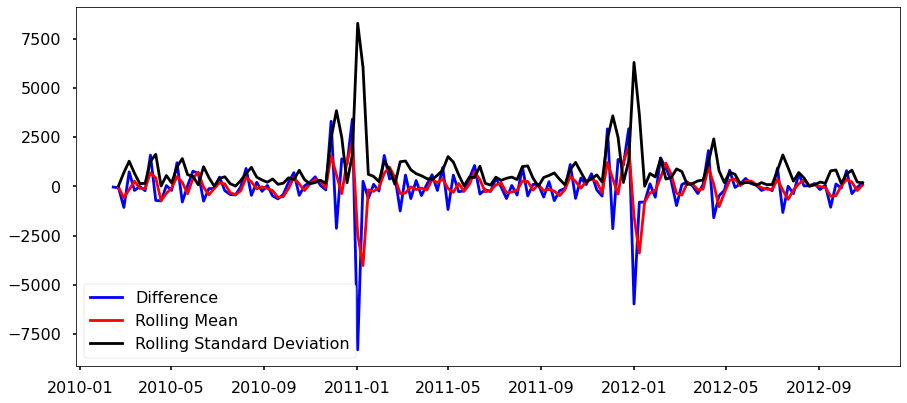

In [206]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 2.Shift

In [106]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data 

In [107]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data 
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

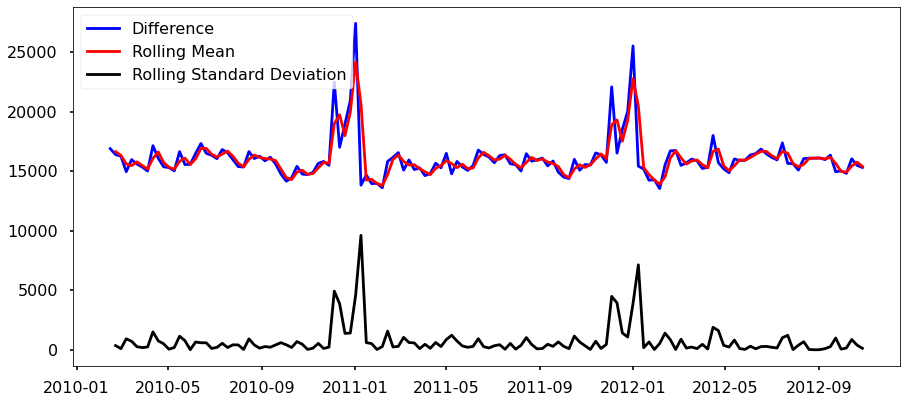

In [108]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 3.Log

In [230]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [231]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

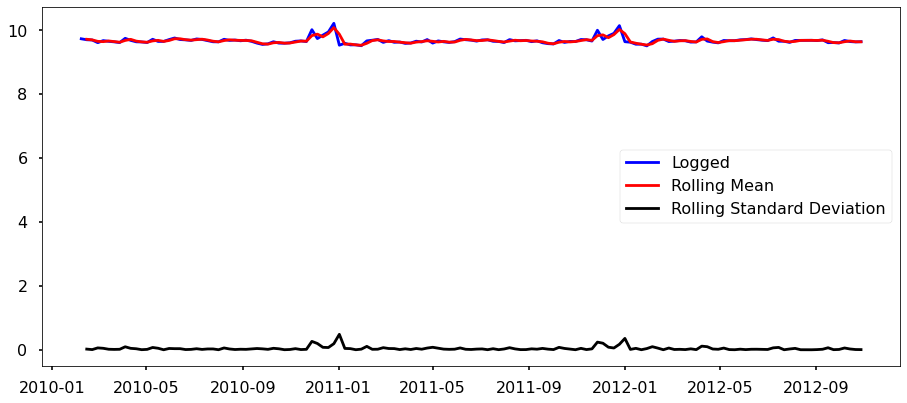

In [232]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

Ww tried our data without any changes, then tried with shifting, taking log and difference version of data. Differenced data gave best results. So, we decided to take difference and use this data. 

# Train-Test Split

In [233]:
train_data_diff = logged_week[:int(0.7*(len(df_week_diff )))]
test_data_diff = logged_week[int(0.7*(len(df_week_diff ))):]

## Simple exponential Smoothing

Observing how different SES model captures training data and make forcasts using our test data

In [234]:
model_1 = sm.tsa.SimpleExpSmoothing(test_data_diff, initialization_method="heuristic")
ses_model_1 = model_1.fit(smoothing_level=0.2, optimized=False)

#model 2
model_2 = sm.tsa.SimpleExpSmoothing(test_data_diff, initialization_method="heuristic")
ses_model_2 = model_2.fit(smoothing_level=0.6, optimized=False)

#model 3
#model_3 = sm.tsa.SimpleExpSmoothing(test_data_diff, initialization_method="estimated")
model_3 = sm.tsa.SimpleExpSmoothing(test_data_diff, initialization_method="heuristic")
#ses_model_3 = model_3.fit()
ses_model_3 = model_3.fit(smoothing_level=0.3, optimized=False)


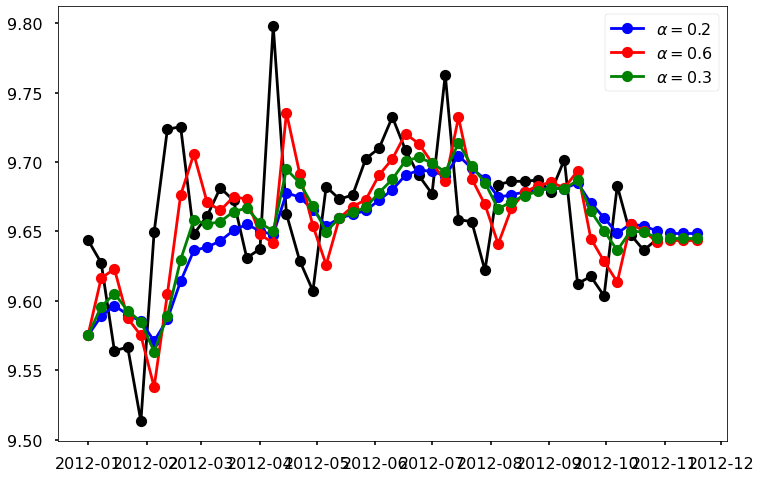

In [235]:
fcast1 = ses_model_1.forecast(3).rename(r"$\alpha=0.2$")
fcast2 = ses_model_2.forecast(3).rename(r"$\alpha=0.6$") 
fcast3 = ses_model_3.forecast(3).rename(r"$\alpha=%s$" % ses_model_3.model.params["smoothing_level"]) 

plt.figure(figsize=(12, 8)) 
plt.plot(test_data_diff, marker="o", color="black") 
plt.plot(ses_model_1.fittedvalues, marker="o", color="blue") 
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(ses_model_2.fittedvalues, marker="o", color="red") 
(line2,) = plt.plot(fcast2, marker="o", color="red") 
plt.plot(ses_model_3.fittedvalues, marker="o", color="green") 
(line3,) = plt.plot(fcast3, marker="o", color="green") 
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

Using our model of choice to make forcast and evaluate

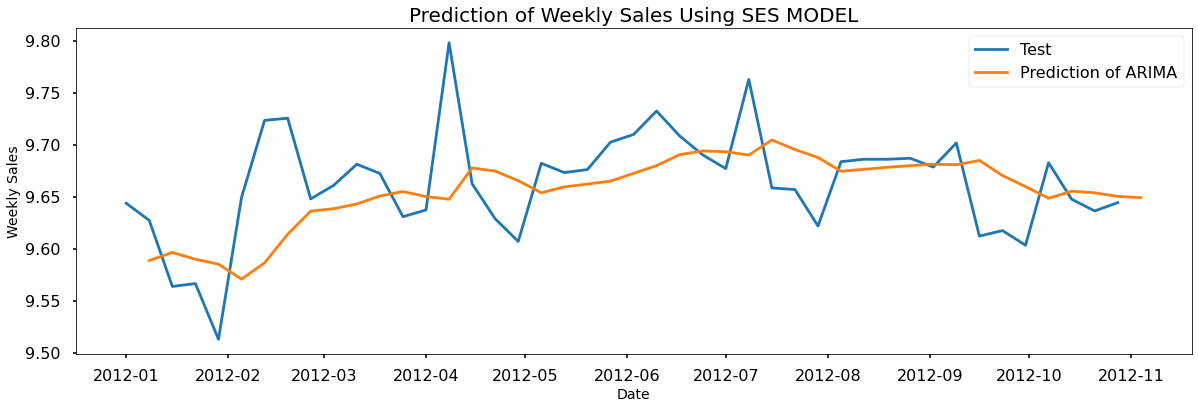

In [236]:
y_pred_1 = ses_model_1.predict(start=1, end=len(test_data_diff))
#y_pred = ses_model.predict()
#y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using SES MODEL', fontsize=20)
#plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred_1, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [237]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f" MAE: {mean_absolute_error(test_data_diff, y_pred_1)}")
print(f" MSE: {mean_squared_error(test_data_diff, y_pred_1)}")
print(f" MAPE: {mean_absolute_percentage_error(test_data_diff, y_pred_1)}")

 MAE: 0.03112437486853027
 MSE: 0.0016885988830390476
 MAPE: 0.003218151355817957


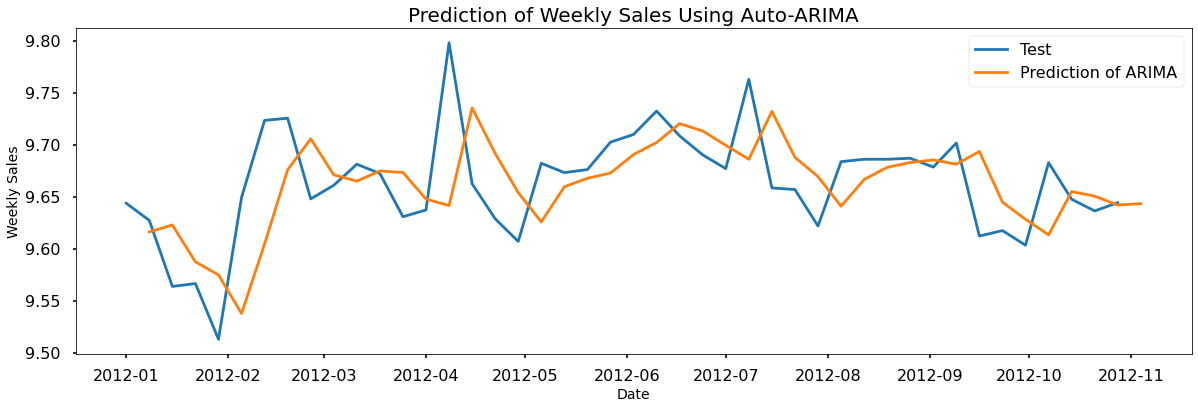

In [238]:
y_pred_2 = ses_model_2.predict(start=1, end=len(test_data_diff))
#y_pred = ses_model.predict()
#y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
#plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred_2, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [239]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f" MAE: {mean_absolute_error(test_data_diff, y_pred_2)}")
print(f" MSE: {mean_squared_error(test_data_diff, y_pred_2)}")
print(f" MAPE: {mean_absolute_percentage_error(test_data_diff, y_pred_2)}")


 MAE: 0.015913208544964617
 MSE: 0.0004367780668041932
 MAPE: 0.0016456571560131993


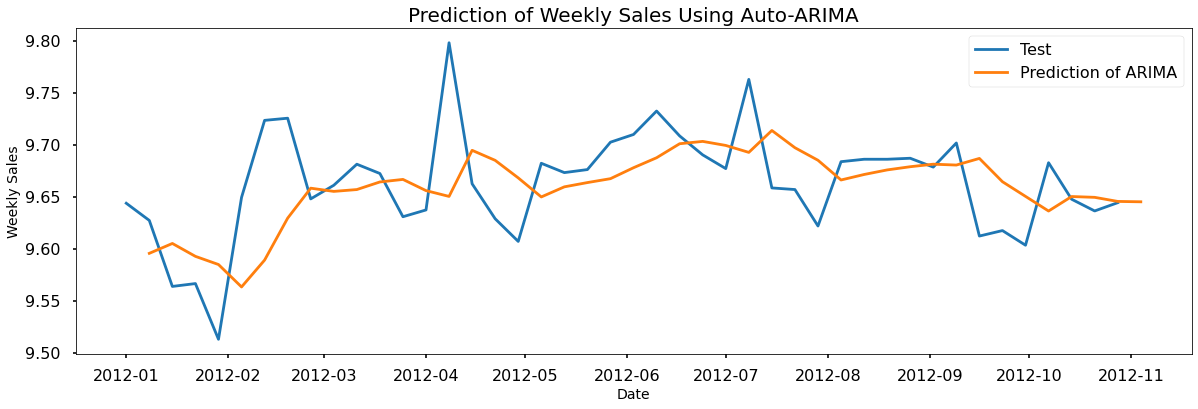

In [240]:
y_pred_3 = ses_model_3.predict(start=1, end=len(test_data_diff))
#y_pred = ses_model.predict()
#y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
#plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred_3, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [241]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f" MAE: {mean_absolute_error(test_data_diff, y_pred_3)}")
print(f" MSE: {mean_squared_error(test_data_diff, y_pred_3)}")
print(f" MAPE: {mean_absolute_percentage_error(test_data_diff, y_pred_3)}")


 MAE: 0.027104423322081406
 MSE: 0.0012628156742040693
 MAPE: 0.0028030500582582507


From above, the second SES performed best

Arima

In [242]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=-153.319, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=-162.595, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=-167.852, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=-166.842, Time=0.22 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=-187.547, Time=0.31 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=-185.610, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=-169.332, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=-170.716, Time=0.66 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=-169.308, Time=0.56 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=-168.237, Time=1.24 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=-185.546, Time=0.84 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=-171.274, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=-169.272, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=-169.787, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=-171.543, Time=1.18 sec
 ARIMA(3,0

ARIMA(maxiter=200, order=(0, 0, 4), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

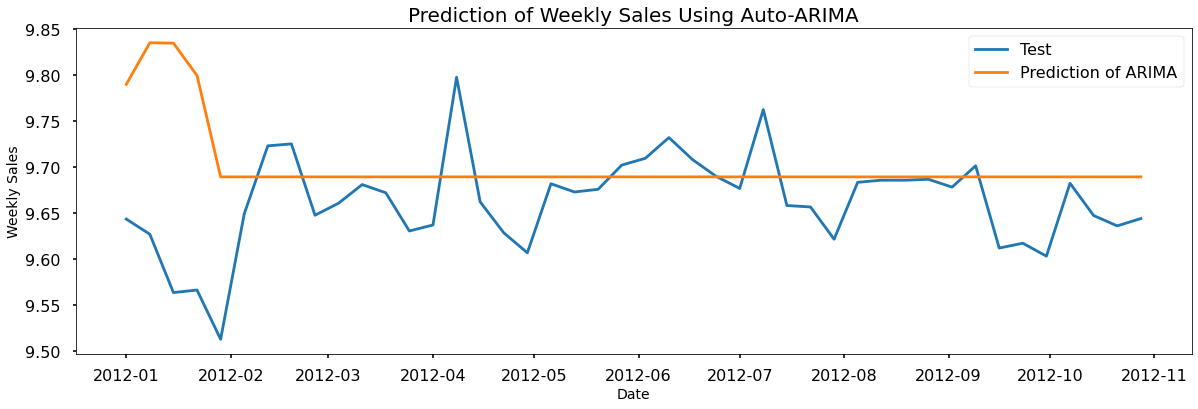

In [243]:
y_pred_a = model_auto_arima.predict(n_periods=len(test_data_diff))
#y_pred_a = pd.DataFrame(y_pred_a,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
#plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred_a, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [244]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f" MAE: {mean_absolute_error(test_data_diff, y_pred_a)}")
print(f" MSE: {mean_squared_error(test_data_diff, y_pred_a)}")
print(f" MAPE: {mean_absolute_percentage_error(test_data_diff, y_pred_a)}")

 MAE: 0.05461233856756112
 MSE: 0.006839969386249033
 MAPE: 0.0056719846699352545


In [125]:
'''
#newly -- usings statsmodel Arima

# ARIMA LİBRARY
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime

# fit model
model2 = ARIMA(train_data_diff, order=(3,0,2)) # (ARMA) = (1,0,1)
model2_fit = model2.fit()
y_pred = model2_fit.predict(start=1, end=4, exog=None, dynamic=False) 
#y_pred = pd.DataFrame(y_pred,columns=['Prediction'])
'''

"\n#newly -- usings statsmodel Arima\n\n# ARIMA LİBRARY\nfrom statsmodels.tsa.arima.model import ARIMA\nfrom pandas import datetime\n\n# fit model\nmodel2 = ARIMA(train_data_diff, order=(3,0,2)) # (ARMA) = (1,0,1)\nmodel2_fit = model2.fit()\ny_pred = model2_fit.predict(start=1, end=4, exog=None, dynamic=False) \n#y_pred = pd.DataFrame(y_pred,columns=['Prediction'])\n"

Trying Sarima

In [245]:
import warnings

aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))

warnings.simplefilter('ignore')

# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(train_data_diff, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan

      

In [246]:
aic_full

,0,1,2,3,4,5
0,0.000000,735.314756,607.598028,498.388231,398.899087,329.680768
1,-136.128305,-132.446725,-154.693876,-152.975839,-94.665432,-135.170532
2,-152.938225,-147.664477,-131.651601,-147.707494,-151.659144,-148.933744
3,-152.757281,-149.320783,-107.632742,-144.185167,-151.439590,-150.540390
4,-156.900675,-144.730836,-159.076897,-151.885366,-153.417100,-152.155093
5,-152.322892,-137.937412,-158.692903,-152.743106,-123.004378,-154.041044


In [256]:
# SARIMA LİBRARY
import statsmodels.api as sm
sarima_model = sm.tsa.statespace.SARIMAX(train_data_diff, order=(4,0,0), seasonal_order=(0,0,1,6), trend='c', enforce_invertibility=False)
sa_results = sarima_model.fit(disp=False)
print(sa_results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                   99
Model:             SARIMAX(4, 0, 0)x(0, 0, [1], 6)   Log Likelihood                  91.815
Date:                             Sat, 11 May 2024   AIC                           -169.631
Time:                                     13:10:37   BIC                           -151.465
Sample:                                 02-07-2010   HQIC                          -162.281
                                      - 12-25-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9065      1.099      2.645      0.008       0.753       5.060
ar.L1          0.3482      

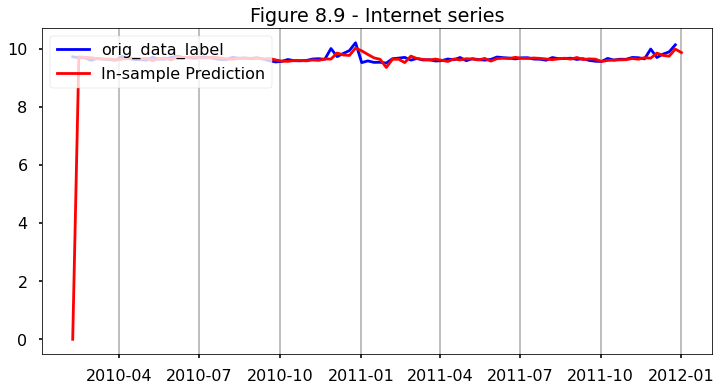

In [257]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = len(test_data_diff)
sa_predict = res.get_prediction(end=mod.nobs + nforecast)
#idx = np.arange(len(sa_predict.predicted_mean))
predict_ci = sa_predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(train_data_diff, 'blue', label="orig_data_label")

# Plot
ax.plot(sa_predict.predicted_mean[:-nforecast], 'red', label='In-sample Prediction')
#ax.plot(sa_predict.predicted_mean[-nforecast:], 'k--', label='Out-of-sample Forecast', linestyle='--', linewidth=2)
#ax.fill_between(train_data_diff, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

ax.set(title='Figure 8.9 - Internet series');
ax.legend(loc='upper left')  # You can adjust the location using options like 'best' or 'lower right'

In [258]:
y_pred_sa = sa_predict.predicted_mean[:-(nforecast + 1)]

In [259]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f" MAE: {mean_absolute_error(train_data_diff, y_pred_sa)}")
print(f" MSE: {mean_squared_error(train_data_diff, y_pred_sa)}")
print(f" MAPE: {mean_absolute_percentage_error(train_data_diff, y_pred_sa)}")

 MAE: 0.15821281453838554
 MSE: 0.9658947402839856
 MAPE: 0.016256424246975917


# ExponentialSmoothing

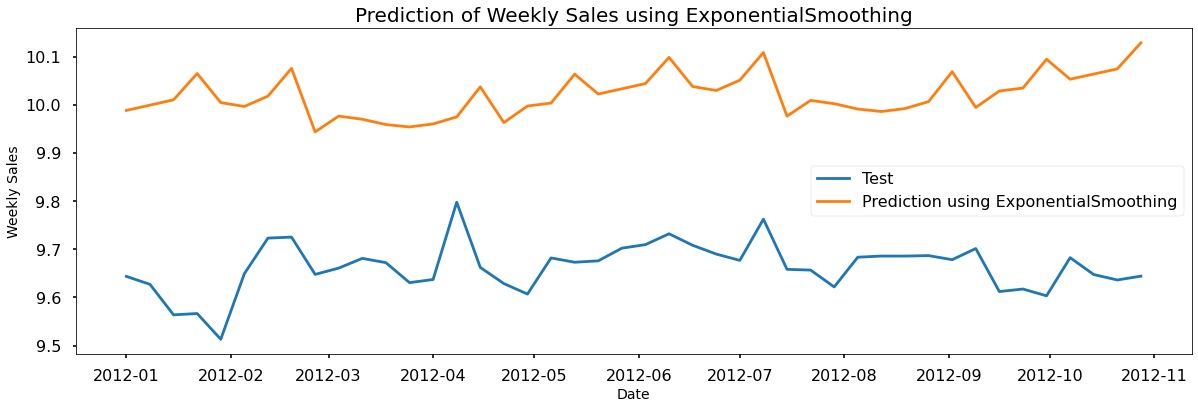

In [260]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred_h = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
#plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred_h, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [261]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f" MAE: {mean_absolute_error(test_data_diff, y_pred_h)}")
print(f" MSE: {mean_squared_error(test_data_diff, y_pred_h)}")
print(f" MAPE: {mean_absolute_percentage_error(test_data_diff, y_pred_h)}")

 MAE: 0.35801665668500265
 MSE: 0.13218328313132302
 MAPE: 0.03707711818356325
